In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.4MB 8.2MB/s 


Load Libraries and Load Data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteGAYK89/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteGAYK89/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Normalize the Data and Create Masks

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

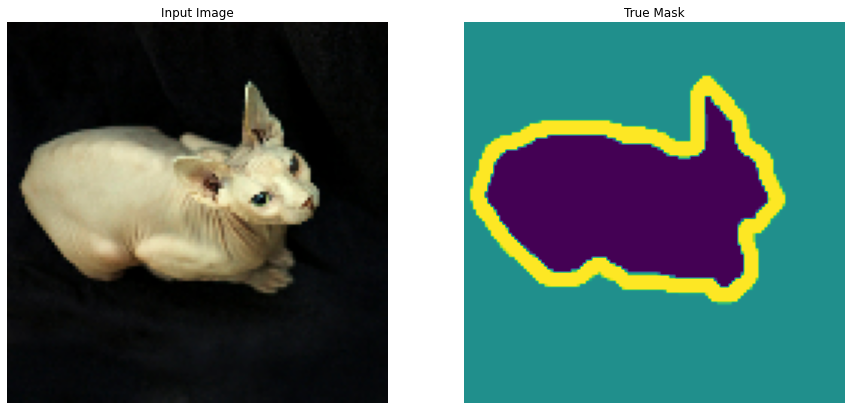

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

Create self defined Mini-UNET

In [ ]:
input_layer = keras.layers.Input(shape = (128, 128, 3))

Conv1 = keras.layers.Conv2D(filters = 64 , kernel_size = (3,3),activation='relu',padding='same')(input_layer)
Conv1 = keras.layers.Conv2D(filters = 64 , kernel_size = (3,3),activation='relu',padding='same')(Conv1)

Pool1 = keras.layers.MaxPooling2D(pool_size=(2,2),padding='same')(Conv1)

Conv2 = keras.layers.Conv2D(filters = 128 , kernel_size = (3,3),activation='relu',padding='same')(Pool1)
Conv2 = keras.layers.Conv2D(filters = 128 , kernel_size = (3,3),activation='relu',padding='same')(Conv2)

Pool2 = keras.layers.MaxPooling2D(pool_size=(2,2),padding='same')(Conv2)

Conv3 = keras.layers.Conv2D(filters = 256 , kernel_size = (3,3),activation='relu',padding='same')(Pool2)
Conv3 = keras.layers.Conv2D(filters = 256 , kernel_size = (3,3),activation='relu',padding='same')(Conv3)


Up_Conv1 = keras.layers.Conv2DTranspose(filters = 256 , kernel_size = (3,3),  strides = (2,2),padding='same')(Conv3)
Merged1 = keras.layers.concatenate([Conv2, Up_Conv1])

R_Conv2 = keras.layers.Conv2D(filters = 128 , kernel_size = (3,3),activation='relu',padding='same')(Merged1)
R_Conv2 = keras.layers.Conv2D(filters = 128 , kernel_size = (3,3),activation='relu',padding='same')(R_Conv2)


Up_Conv2 = keras.layers.Conv2DTranspose(filters = 128 , kernel_size = (3,3),  strides = (2,2),padding='same')(R_Conv2)
Merged2 = keras.layers.concatenate([Conv1, Up_Conv2])

R_Conv1 = keras.layers.Conv2D(filters = 64 , kernel_size = (3,3),activation='relu',padding='same')(Merged2)
R_Conv1 = keras.layers.Conv2D(filters = 64 , kernel_size = (3,3),activation='relu',padding='same')(R_Conv1)



Output = keras.layers.Conv2D(filters = 3 , kernel_size = (1,1),padding='same')(R_Conv1)


In [ ]:
model = keras.Model(inputs=input_layer, outputs=Output)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 128, 128, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_44[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_45[0][0]                  
____________________________________________________________________________________________

Compile Model and Plot it

In [ ]:
#model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

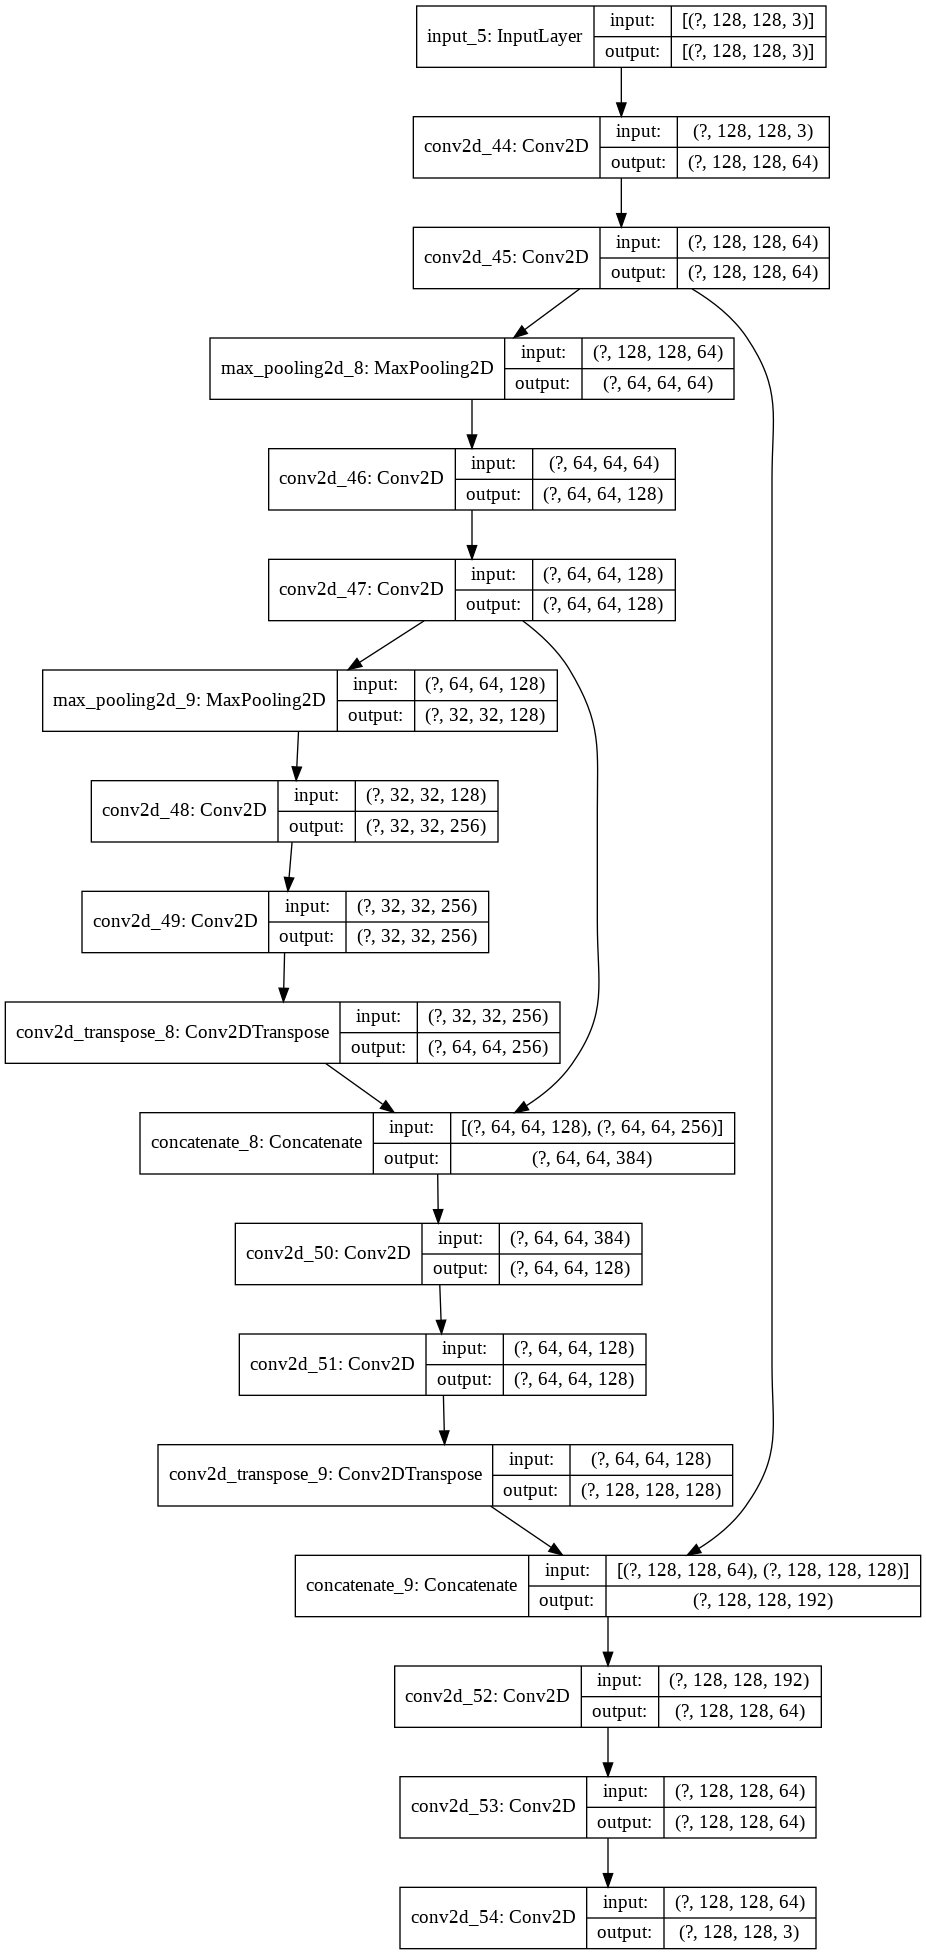

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

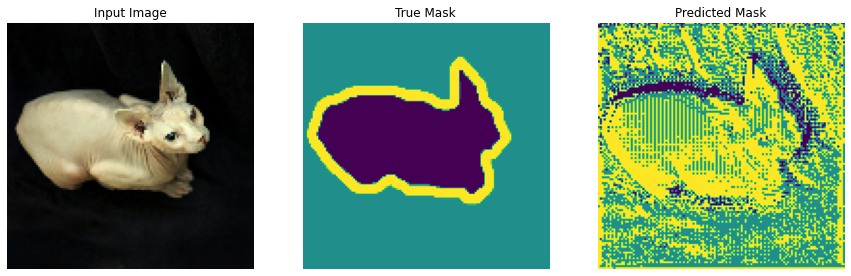

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions()

Make Predictions and Plot Predictions

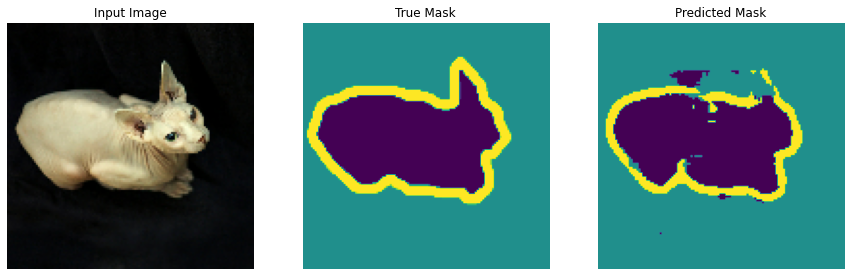


Sample Prediction after epoch 20

57/57 [==============================] - 23s 396ms/step - loss: 0.3542 - accuracy: 0.8529 - val_loss: 0.3762 - val_accuracy: 0.8474


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

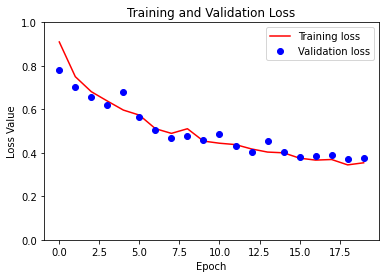

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

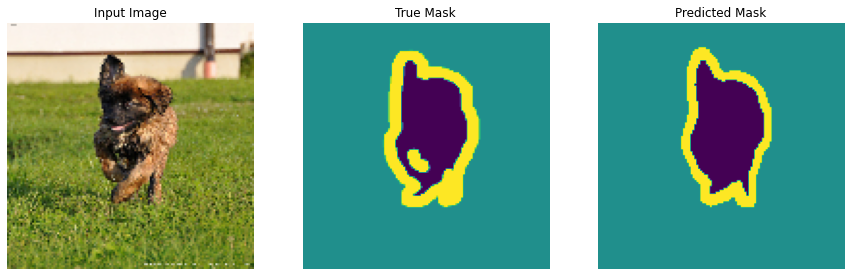

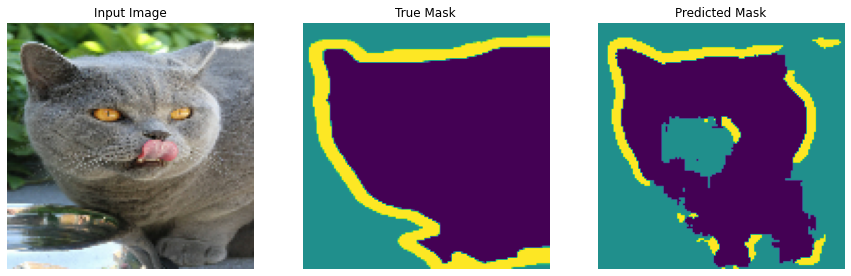

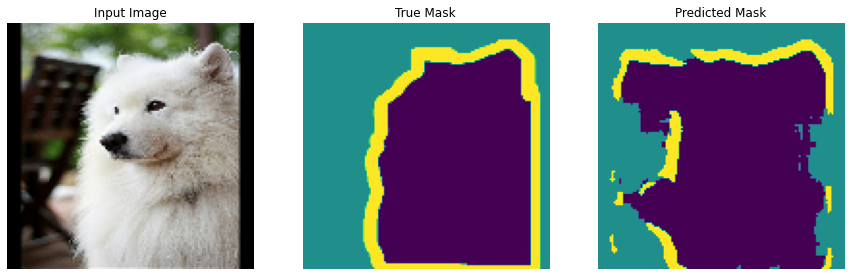

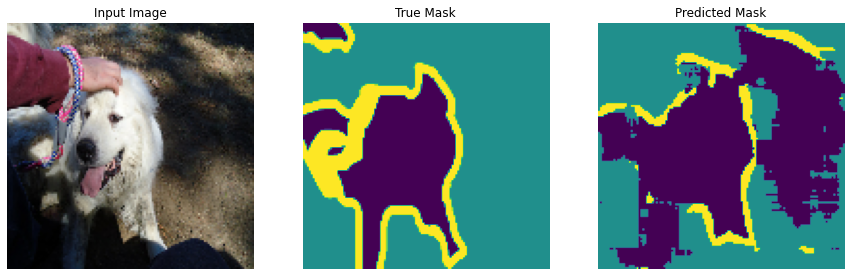

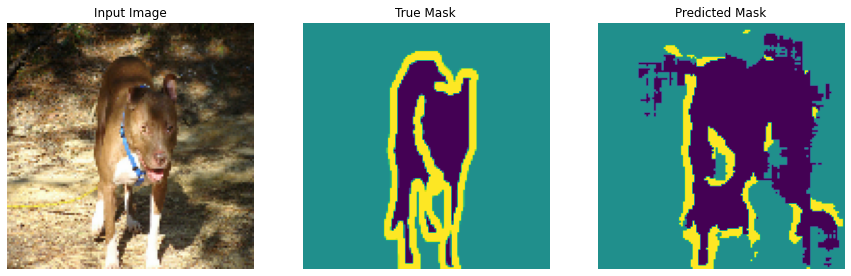

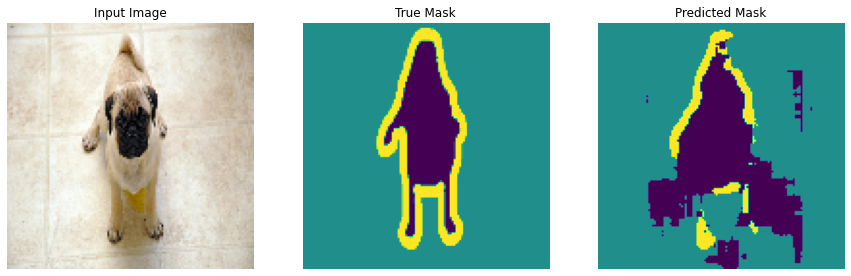

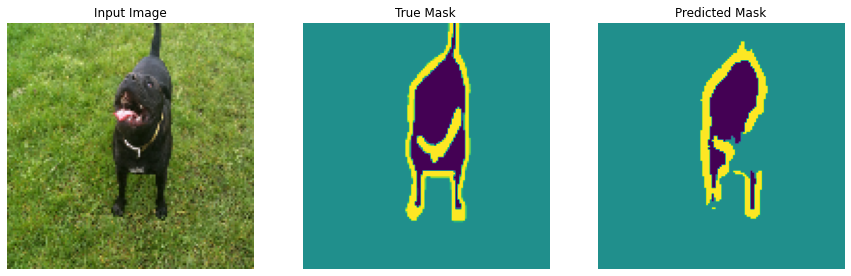

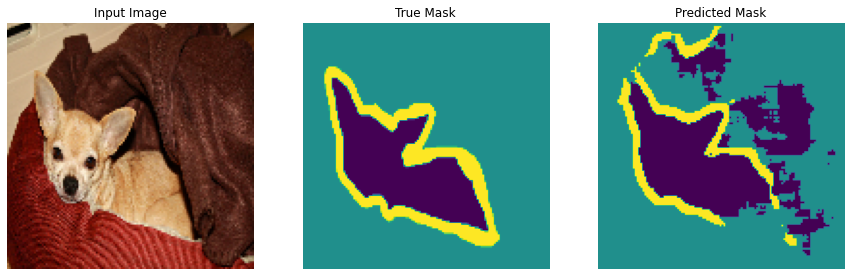

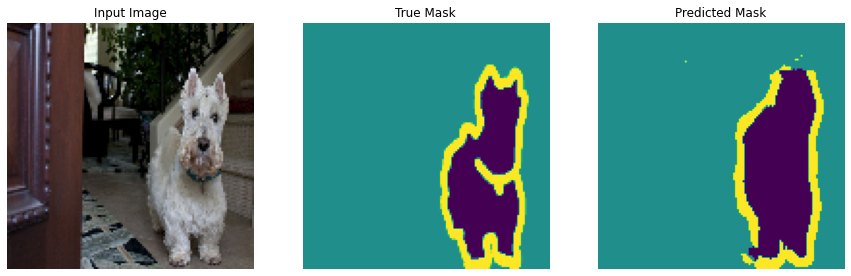

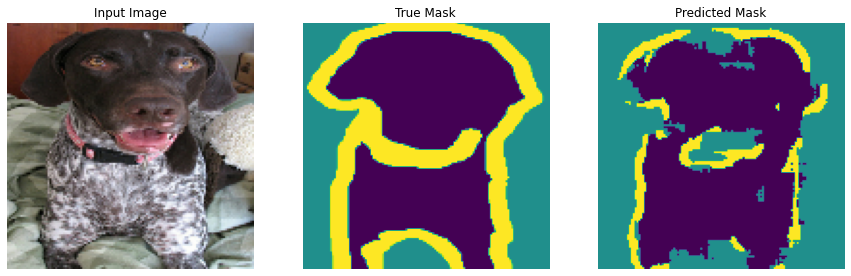

In [ ]:
show_predictions(test_dataset, 10)